In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import scipy

import torch
from torch import nn, optim
from torch.nn import functional as F

from src import data
from src.detm import DETM

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

from analysis_utils import get_detm_topics, topic_diversity

/home/users/amarvenu/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [3]:
### data and file related arguments
arg_str = """
parser.add_argument('--dataset', type=str, default='un', help='name of corpus')
parser.add_argument('--data_path', type=str, default='un/', help='directory containing data')
parser.add_argument('--emb_path', type=str, default='skipgram/embeddings.txt', help='directory containing embeddings')
parser.add_argument('--save_path', type=str, default='./results', help='path to save results')
parser.add_argument('--batch_size', type=int, default=1000, help='number of documents in a batch for training')
parser.add_argument('--min_df', type=int, default=100, help='to get the right data..minimum document frequency')

### model-related arguments
parser.add_argument('--num_topics', type=int, default=50, help='number of topics')
parser.add_argument('--rho_size', type=int, default=300, help='dimension of rho')
parser.add_argument('--emb_size', type=int, default=300, help='dimension of embeddings')
parser.add_argument('--t_hidden_size', type=int, default=800, help='dimension of hidden space of q(theta)')
parser.add_argument('--theta_act', type=str, default='relu', help='tanh, softplus, relu, rrelu, leakyrelu, elu, selu, glu)')
parser.add_argument('--train_embeddings', type=int, default=1, help='whether to fix rho or train it')
parser.add_argument('--eta_nlayers', type=int, default=3, help='number of layers for eta')
parser.add_argument('--eta_hidden_size', type=int, default=200, help='number of hidden units for rnn')
parser.add_argument('--delta', type=float, default=0.005, help='prior variance')

### optimization-related arguments
parser.add_argument('--lr', type=float, default=0.005, help='learning rate')
parser.add_argument('--lr_factor', type=float, default=4.0, help='divide learning rate by this')
parser.add_argument('--epochs', type=int, default=100, help='number of epochs to train')
parser.add_argument('--mode', type=str, default='train', help='train or eval model')
parser.add_argument('--optimizer', type=str, default='adam', help='choice of optimizer')
parser.add_argument('--seed', type=int, default=2019, help='random seed (default: 1)')
parser.add_argument('--enc_drop', type=float, default=0.0, help='dropout rate on encoder')
parser.add_argument('--eta_dropout', type=float, default=0.0, help='dropout rate on rnn for eta')
parser.add_argument('--clip', type=float, default=0.0, help='gradient clipping')
parser.add_argument('--nonmono', type=int, default=10, help='number of bad hits allowed')
parser.add_argument('--wdecay', type=float, default=1.2e-6, help='some l2 regularization')
parser.add_argument('--anneal_lr', type=int, default=0, help='whether to anneal the learning rate or not')
parser.add_argument('--bow_norm', type=int, default=1, help='normalize the bows or not')

### evaluation, visualization, and logging-related arguments
parser.add_argument('--num_words', type=int, default=20, help='number of words for topic viz')
parser.add_argument('--log_interval', type=int, default=10, help='when to log training')
parser.add_argument('--visualize_every', type=int, default=1, help='when to visualize results')
parser.add_argument('--eval_batch_size', type=int, default=1000, help='input batch size for evaluation')
parser.add_argument('--load_from', type=str, default='', help='the name of the ckpt to eval from')
parser.add_argument('--tc', type=int, default=0, help='whether to compute tc or not')
""".split('\n')

In [4]:
keys = [x.strip("parser.add_argument('").split(',')[0].strip('--').strip("'") for x in arg_str if (len(x) > 0) and (not x.startswith('#'))]
values = [x.strip("parser.add_argument('").split(',')[2].strip(" default=").strip("'") for x in arg_str if (len(x) > 0) and (not x.startswith('#'))]
tmp_dict = dict(zip(keys, values))

for k, v in tmp_dict.items():
    if v.isnumeric():
        tmp_dict[k] = int(v)
    elif ('.' in v) and (v[0].isnumeric()):
        tmp_dict[k] = float(v)    

args = AttrDict()
args.update(tmp_dict)

args.train_embeddings = 0
args.rho_size = 768
args.num_topics = 10
args.batch_size = 100
args.epochs = 150

In [5]:
train_arr = np.load('test_data.npz', allow_pickle=True)

In [6]:
train_tokens = train_arr['train_tokens']
train_counts = train_arr['train_counts']
train_times = train_arr['train_times']
vocab = train_arr['vocab']
embeddings = train_arr['embeddings']

args.num_times = len(np.unique(train_times))
args.num_docs_train = len(train_tokens)
args.vocab_size = len(vocab)
args.num_words = 10

In [16]:
%%time
train_rnn_inp = data.get_rnn_input(train_tokens, train_counts, train_times, args.num_times, args.vocab_size, args.num_docs_train)

idx: 0/2
CPU times: user 2.92 s, sys: 543 ms, total: 3.46 s
Wall time: 314 ms


In [7]:
if not os.path.exists(args['save_path']):
    os.makedirs(args['save_path'])

In [8]:
if args.mode == 'eval':
    ckpt = args.load_from
else:
    ckpt = os.path.join(args.save_path, 
        'bert_detm_{}_K_{}_Htheta_{}_Optim_{}_Clip_{}_ThetaAct_{}_Lr_{}_Bsz_{}_RhoSize_{}_L_{}_minDF_{}_trainEmbeddings_{}'.format(
        args.dataset, args.num_topics, args.t_hidden_size, args.optimizer, args.clip, args.theta_act, 
            args.lr, args.batch_size, args.rho_size, args.eta_nlayers, args.min_df, args.train_embeddings))

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embeddings = torch.from_numpy(embeddings).to(device)
args.embeddings_dim = embeddings.size()

model = DETM(args, embeddings)
model.to(device)

DETM(
  (t_drop): Dropout(p=0.0, inplace=False)
  (theta_act): ReLU()
  (q_theta): Sequential(
    (0): Linear(in_features=4948, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (q_eta_map): Linear(in_features=4938, out_features=200, bias=True)
  (q_eta): LSTM(200, 200, num_layers=3)
  (mu_q_eta): Linear(in_features=210, out_features=10, bias=True)
  (logsigma_q_eta): Linear(in_features=210, out_features=10, bias=True)
)

In [20]:
if args.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wdecay)
elif args.optimizer == 'adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.wdecay)
elif args.optimizer == 'adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr, weight_decay=args.wdecay)
elif args.optimizer == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.wdecay)
elif args.optimizer == 'asgd':
    optimizer = optim.ASGD(model.parameters(), lr=args.lr, t0=0, lambd=0., weight_decay=args.wdecay)
else:
    print('Defaulting to vanilla SGD')
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

In [21]:
def train(epoch):
    """Train DETM on data for one epoch.
    """
    model.train()
    acc_loss = 0
    acc_nll = 0
    acc_kl_theta_loss = 0
    acc_kl_eta_loss = 0
    acc_kl_alpha_loss = 0
    cnt = 0
    indices = torch.randperm(args.num_docs_train)
    indices = torch.split(indices, args.batch_size) 
    for idx, ind in enumerate(indices):
        optimizer.zero_grad()
        model.zero_grad()
        data_batch, times_batch = data.get_batch(
            train_tokens, train_counts, ind, args.vocab_size, args.emb_size, temporal=True, times=train_times)
        sums = data_batch.sum(1).unsqueeze(1)
        if args.bow_norm:
            normalized_data_batch = data_batch / sums
        else:
            normalized_data_batch = data_batch

        loss, nll, kl_alpha, kl_eta, kl_theta = model(data_batch, normalized_data_batch, times_batch, train_rnn_inp, args.num_docs_train)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        acc_loss += torch.sum(loss).item()
        acc_nll += torch.sum(nll).item()
        acc_kl_theta_loss += torch.sum(kl_theta).item()
        acc_kl_eta_loss += torch.sum(kl_eta).item()
        acc_kl_alpha_loss += torch.sum(kl_alpha).item()
        cnt += 1

        if idx % args.log_interval == 0 and idx > 0:
            cur_loss = round(acc_loss / cnt, 2) 
            cur_nll = round(acc_nll / cnt, 2) 
            cur_kl_theta = round(acc_kl_theta_loss / cnt, 2) 
            cur_kl_eta = round(acc_kl_eta_loss / cnt, 2) 
            cur_kl_alpha = round(acc_kl_alpha_loss / cnt, 2) 
            lr = optimizer.param_groups[0]['lr']
            print('Epoch: {} .. batch: {}/{} .. LR: {} .. KL_theta: {} .. KL_eta: {} .. KL_alpha: {} .. Rec_loss: {} .. NELBO: {}'.format(
                epoch, idx, len(indices), lr, cur_kl_theta, cur_kl_eta, cur_kl_alpha, cur_nll, cur_loss))
    
    cur_loss = round(acc_loss / cnt, 2) 
    cur_nll = round(acc_nll / cnt, 2) 
    cur_kl_theta = round(acc_kl_theta_loss / cnt, 2) 
    cur_kl_eta = round(acc_kl_eta_loss / cnt, 2) 
    cur_kl_alpha = round(acc_kl_alpha_loss / cnt, 2) 
    lr = optimizer.param_groups[0]['lr']
    print('*'*100)
    print('Epoch----->{} .. LR: {} .. KL_theta: {} .. KL_eta: {} .. KL_alpha: {} .. Rec_loss: {} .. NELBO: {}'.format(
            epoch, lr, cur_kl_theta, cur_kl_eta, cur_kl_alpha, cur_nll, cur_loss))
    print('*'*100)

In [24]:
%%time
## train model on data by looping through multiple epochs
best_epoch = 0
best_val_ppl = 1e9
all_val_ppls = []
for epoch in range(1, args.epochs):
    train(epoch)
    ## check whether to anneal lr
    lr = optimizer.param_groups[0]['lr']
    if args.anneal_lr and (len(all_val_ppls) > args.nonmono and val_ppl > min(all_val_ppls[:-args.nonmono]) and lr > 1e-5):
        optimizer.param_groups[0]['lr'] /= args.lr_factor
    #all_val_ppls.append(val_ppl)
model.eval()
with torch.no_grad():
    print('saving topic matrix beta...')
    alpha = model.mu_q_alpha
    beta = model.get_beta(alpha).cpu().numpy()
    scipy.io.savemat(ckpt+'_beta.mat', {'values': beta}, do_compression=True)
    if args.train_embeddings:
        print('saving word embedding matrix rho...')
        rho = model.rho.weight.cpu().numpy()
        scipy.io.savemat(ckpt+'_rho.mat', {'values': rho}, do_compression=True)

Epoch: 1 .. batch: 10/17 .. LR: 0.005 .. KL_theta: 17713.67 .. KL_eta: 3175.82 .. KL_alpha: 11701875.27 .. Rec_loss: 20134262.18 .. NELBO: 31857027.27
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 21019.38 .. KL_eta: 2439.99 .. KL_alpha: 11547434.12 .. Rec_loss: 20008464.47 .. NELBO: 31579358.24
****************************************************************************************************
Epoch: 2 .. batch: 10/17 .. LR: 0.005 .. KL_theta: 19563.38 .. KL_eta: 400.39 .. KL_alpha: 10816257.91 .. Rec_loss: 19639478.36 .. NELBO: 30475700.36
****************************************************************************************************
Epoch----->2 .. LR: 0.005 .. KL_theta: 19550.35 .. KL_eta: 325.96 .. KL_alpha: 10650328.94 .. Rec_loss: 19664786.59 .. NELBO: 30334992.0
****************************************************************************************************
Epoch: 3 .. batch: 

## see if i can get a measure of topic coherence

In [10]:
df = pd.read_parquet('data/combined_clean.parquet')
id2word = Dictionary([vocab])
split_text = df['filtered_text'].str.split().values

In [11]:
args.num_words = 10

In [71]:
with torch.no_grad():
    alpha = model.mu_q_alpha
    beta = model.get_beta(alpha) 
    print('beta: ', beta.size())
    print('\n')
    print('#'*100)
    print('Visualize topics...')
    times = [0, 2]
    topics_words = []
    for k in range(args.num_topics):
        for t in times:
            gamma = beta[k, t, :]
            top_words = list(gamma.cpu().numpy().argsort()[-args.num_words+1:][::-1])
            topic_words = [id2word[a] for a in top_words]
            topics_words.append(' '.join(topic_words))
            print('Topic {} .. Time: {} ===> {}'.format(k, t, topic_words)) 

beta:  torch.Size([10, 4, 4938])


####################################################################################################
Visualize topics...
Topic 0 .. Time: 0 ===> ['financial', 'loan', 'system', 'credit', 'bank', 'asset', 'payment', 'security', 'reserve']
Topic 0 .. Time: 2 ===> ['financial', 'asset', 'bank', 'fund', 'system', 'payment', 'security', 'credit', 'reserve']
Topic 1 .. Time: 0 ===> ['underlie', 'remark', 'examiner', 'subprime', 'foreclosure', 'intermediary', 'clearing', 'induce', 'insure']
Topic 1 .. Time: 2 ===> ['remark', 'subprime', 'foreclosure', 'examiner', 'underlie', 'clearing', 'intermediary', 'insure', 'nonprime']
Topic 2 .. Time: 0 ===> ['productivity', 'business', 'growth', 'technology', 'investment', 'economy', 'labor', 'development', 'saving']
Topic 2 .. Time: 2 ===> ['labor', 'growth', 'business', 'work', 'job', 'productivity', 'research', 'development', 'worker']
Topic 3 .. Time: 0 ===> ['price', 'effect', 'demand', 'expectation', 'level', 'c

In [65]:
coherences = []
for t in tqdm(range(args.num_times)):
    coherences.append(
        CoherenceModel(
            topics=get_detm_topics(beta=beta, time=t, num_words=20, vocab=id2word, num_topics=args.num_topics), # use 20 words to standardize with DTM
            texts=split_text, 
            dictionary=id2word, 
            coherence='c_v'
        ).get_coherence()
    )

coherences = np.array(coherences)

100%|██████████| 4/4 [00:52<00:00, 13.07s/it]


In [66]:
def topic_diversity(topics):
    all_words = set(np.concatenate(topics))
    return len(all_words) / (len(topics[0]) * len(topics))

In [67]:
diversities = []
for t in tqdm(range(args.num_times)):
    diversities.append(
        topic_diversity(topics=get_detm_topics(beta=beta, time=t, num_words=20, vocab=id2word, num_topics=args.num_topics))
    )
    
diversities = np.array(diversities)

100%|██████████| 4/4 [00:00<00:00, 207.43it/s]


In [68]:
qualities = diversities * coherences
qualities.mean(), qualities.std()

(0.3795111696155748, 0.003672591640759064)

In [73]:
coherences, diversities

(array([0.43669734, 0.43612565, 0.43312171, 0.42893962]),
 array([0.875, 0.875, 0.88 , 0.87 ]))

In [70]:
np.savez_compressed(
    'detm_stats_bert.npz',
    coherence=coherences,
    diversity=diversities
)

## try to dig into topic evolutions

In [9]:
beta = scipy.io.loadmat('results/bert_detm_un_K_10_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.005_Bsz_100_RhoSize_768_L_3_minDF_100_trainEmbeddings_0_beta.mat')['values']

In [12]:
def get_word_probs(word, topic, beta):
    word_id = id2word.token2id[word]
    probs = []
    for t in range(4):
        gamma = beta[topic, t, :]
        probs.append(gamma[word_id])
    return probs

In [ ]:
## make some plots

In [13]:
import matplotlib.pyplot as plt

In [16]:
plot_df = pd.DataFrame({
    'credit': get_word_probs('credit', 0, beta),
    'security': get_word_probs('security', 0, beta),
    'foreclosure': get_word_probs('foreclosure', 1, beta),
    'subprime': get_word_probs('subprime', 1, beta),
    'labor': get_word_probs('labor', 2, beta),
    'technology': get_word_probs('technology', 2, beta),
    'vol': get_word_probs('vol', 3, beta),
    'demand': get_word_probs('demand', 3, beta),
    'regulation': get_word_probs('regulation', 5, beta),
    'requirement': get_word_probs('requirement', 5, beta),
    'inflation': get_word_probs('inflation', 8, beta),
    'unemployment': get_word_probs('unemployment', 8, beta),
    'stress': get_word_probs('stress', 9, beta),
})

plot_df.to_csv('bert_evolve.csv', index=False)

<Axes: >

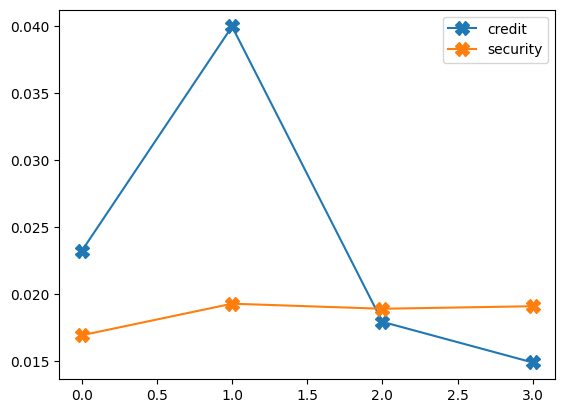

In [15]:
plot_df[['credit', 'security']].plot(marker='X', markersize=10)

<Axes: >

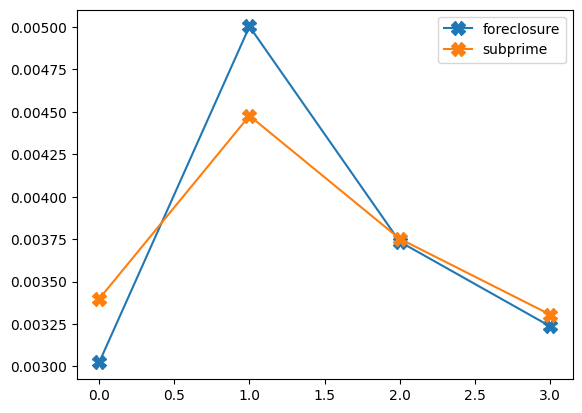

In [99]:
plot_df[['foreclosure', 'subprime']].plot(marker='X', markersize=10)

<Axes: >

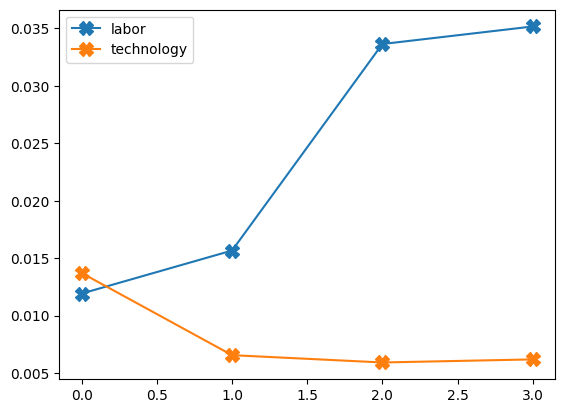

In [100]:
plot_df[['labor', 'technology']].plot(marker='X', markersize=10)

<Axes: >

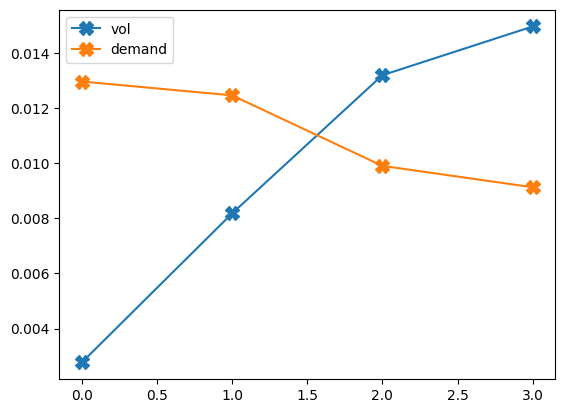

In [101]:
plot_df[['vol', 'demand']].plot(marker='X', markersize=10)

<Axes: >

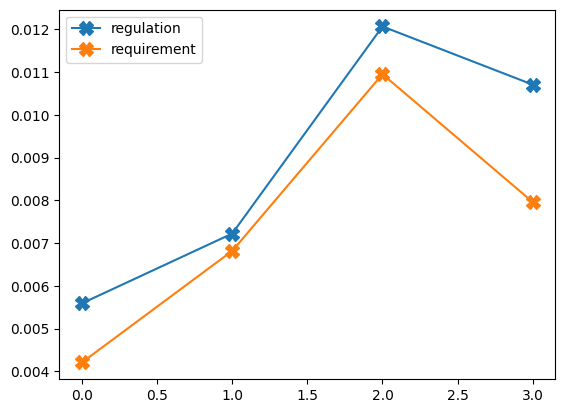

In [102]:
plot_df[['regulation', 'requirement']].plot(marker='X', markersize=10)

<Axes: >

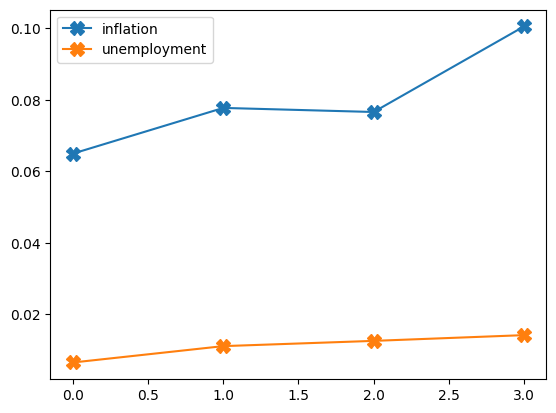

In [103]:
plot_df[['inflation', 'unemployment']].plot(marker='X', markersize=10)